In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# load local model file and initialize model class
from model import ModelClass

model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

model.solve()
model.simulate()

In [114]:
means_data = pd.read_csv("Data/mean_matrix.csv")

In [132]:
assets = np.array(means_data["formue_2018_Mean"])
savings = np.array(means_data["pension_2018_Mean"])
hours = np.array(means_data["yearly_hours_Mean"])/par.full_time_hours

In [133]:
mean = np.concatenate([assets, 
                       savings, 
                       hours])

In [116]:
covariance_matrix = pd.read_csv("Data/variance_matrix.csv")

numeric_cols = covariance_matrix.select_dtypes(include=[np.number]).columns[1:]

row_mask = covariance_matrix["_NAME_"].str.startswith("yearly_hours")
col_mask = [col for col in covariance_matrix.columns if col.startswith("yearly_hours")]

covariance_matrix.loc[row_mask, numeric_cols] = covariance_matrix.loc[row_mask, numeric_cols].astype(float)

covariance_matrix.loc[row_mask, numeric_cols] /= par.full_time_hours

covariance_matrix[col_mask] /= par.full_time_hours

In [125]:
weights = np.linalg.inv(np.nan_to_num(covariance_matrix[numeric_cols].to_numpy(), nan=0))

In [128]:
def moment_func(sim_data):
    # Compute age-averaged moments
    avg_a_by_age = np.mean(sim_data.a, axis=0)  # Length 70
    avg_s_by_age = np.mean(sim_data.s, axis=0)  # Length 70
    avg_h_by_age = np.mean(sim_data.h, axis=0)  # Length 70

    # Concatenate and return
    return np.concatenate((avg_a_by_age, avg_s_by_age, avg_h_by_age))


def simulate_moments(theta, theta_names, model):
        
    # 1. Update model parameters
    for i, name in enumerate(theta_names):
        setattr(model.par, name, theta[i])
    
    # 2. Solve and simulate the model
    model.solve()
    model.simulate()
    
    # 3. Return the expanded vector of simulated moments
    return moment_func(model.sim)

def obj_func(theta, theta_names, mom_data, W, model, do_print=False):
    start_time = time.time()  # Start timing

    if do_print: 
        print_str = ''
        for i, name in enumerate(theta_names):
            print_str += f'{name}={theta[i]:2.3f} '
        print(print_str)
    
    # Compute simulated moments
    mom_sim = simulate_moments(theta, theta_names, model)

    # Sum of squared errors over all 175 elements
    obj = (mom_data - mom_sim).T @ W @ (mom_data - mom_sim)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    
    if do_print: 
        print(f"Error = {obj:.6f}, Time = {elapsed_time:.4f} seconds")

    return obj



In [129]:

theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")

objective = lambda theta: obj_func(theta, theta_names, mean, weights, model, do_print=True)

theta_init = np.array([0.976, 1.026, 4.723, 7.887, 0.015, 0.009])

res = minimize(
    objective, 
    theta_init,
    method='trust-constr',
    bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 10.0), (0.0, 10.0), (0.0, 0.02), (0.0, 0.1)],
    tol=1e-6,
    options={"maxiter":10000}
)


beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 27.369992, Time = 5.5243 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 27.369997, Time = 6.7758 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 27.369987, Time = 6.2004 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 27.369995, Time = 6.2720 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 27.369994, Time = 6.2454 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 27.369998, Time = 6.2359 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 27.369994, Time = 6.2527 seconds
beta=0.696 sigma=1.367 gamma=4.666 mu=7.865 r_s=-0.164 r_a=-0.034 
Error = 108.818233, Time = 5.3655 seconds
beta=0.696 sigma=1.367 gamma=4.666 mu=7.865 r_s=-0.164 r_a=-0.034 
Error = 108.818233, Time = 5.3969 seconds
beta=0.696 sigma=1.367 gamma=4.666 mu=7.

Traceback (most recent call last):
  File "c:\Users\B465929\AppData\Local\anaconda3\Lib\site-packages\numba\core\serialize.py", line 30, in _numba_unpickle
    def _numba_unpickle(address, bytedata, hashed):
    
KeyboardInterrupt

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x000002171AF38860> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x000002171AF38860> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x000002171AF38860> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x000002171AF38860> returned a result with an exception set

The above exception was the direct cause of the following exception:

System

SystemError: CPUDispatcher(<function main_solver_loop at 0x000002171DC71F80>) returned a result with an exception set

In [131]:
# beta=0.941 sigma=1.097 gamma=4.714 mu=7.888 r_s=0.011 r_a=0.011 


theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")
# theta_init = np.array(res.x)
theta_init = np.array([0.941, 1.097, 4.714, 7.888, 0.011, 0.011])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_init[i])

model.solve()
model.simulate()

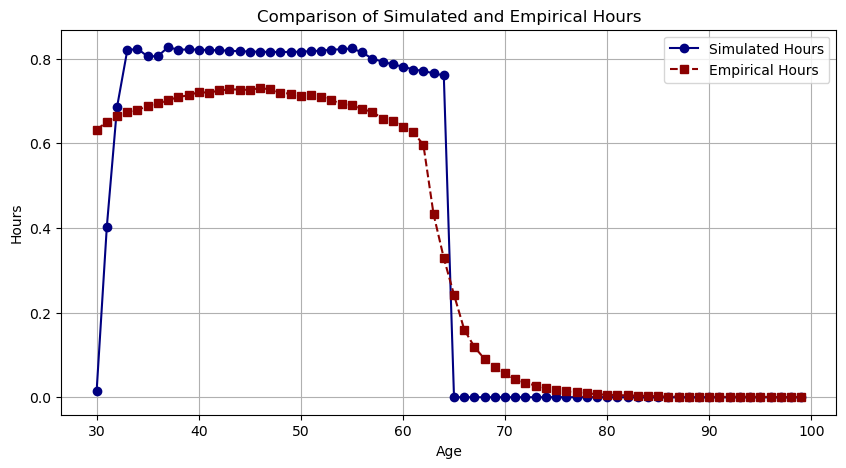

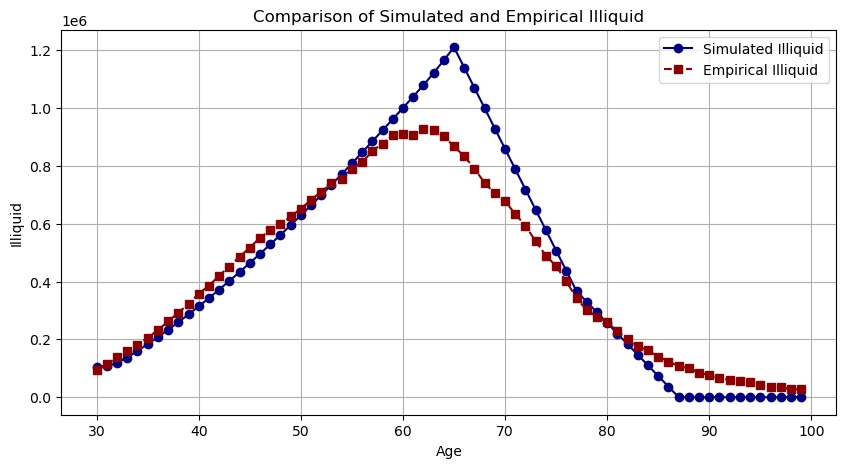

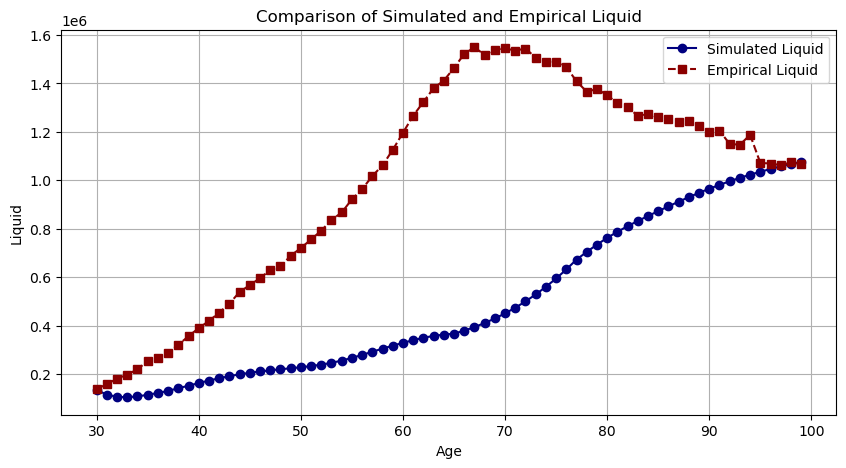

In [136]:
a_dict = {
    'hours': [np.mean(model.sim.h, axis=0), hours],
    'illiquid': [np.mean(model.sim.s, axis=0), savings],
    'liquid': [np.mean(model.sim.a, axis=0), assets]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()
